# Ví dụ 1

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
means = [[2,2],[8,3],[3,6]]
cov = [[1,0],[0,1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
X = np.concatenate((X0,X1,X2), axis=0)
K = 3
original_label = np.asarray([0]*N + [1]*N + [2]*N).T

In [3]:
def kmeans_display(X, label):
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8)
    plt.axis('equal')
    plt.plot()
    plt.show()

In [4]:
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

In [5]:
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

In [6]:
def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

In [7]:
def has_converged(centers, new_centers):
# return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

In [8]:
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

Centers found by our algorithm:
[[2.01882687 1.89707673]
 [2.9974665  6.01077277]
 [7.98865168 2.94427522]]


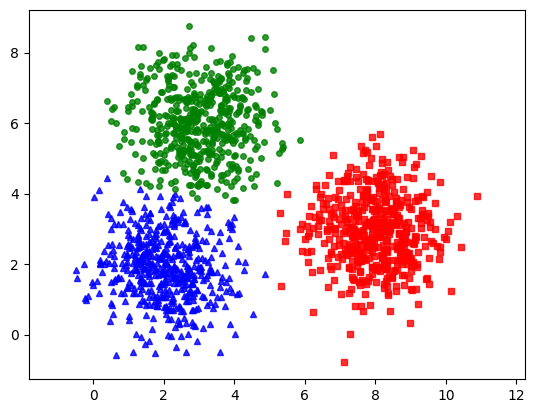

In [9]:
(centers, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:')
print(centers[-1])
kmeans_display(X, labels[-1])

Centers found by scikit-learn:
[[7.98865168 2.94427522]
 [2.99613723 6.00681022]
 [2.01821172 1.89280634]]


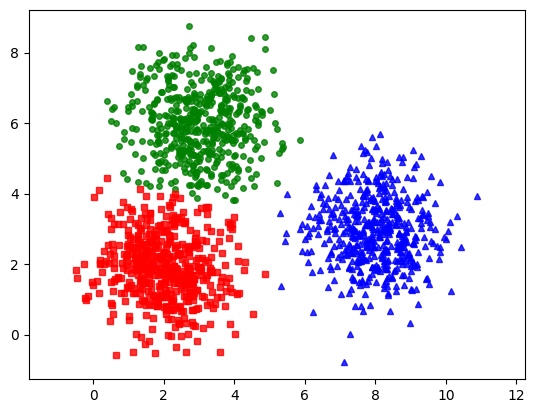

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print('Centers found by scikit-learn:')
print(kmeans.cluster_centers_)
pred_label = kmeans.predict(X)
kmeans_display(X, pred_label)

# Ví Dụ 2

In [22]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

In [23]:
def display_network(A, m=-1, n=-1):
    opt_normalize = True
    opt_graycolor = True

    # Rescale
    A = A - np.average(A)

    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    if m < 0 or n < 0:
        n = np.ceil(np.sqrt(col))
        m = np.ceil(col / n)

    image = np.ones(shape=(buf + int(m) * (sz + buf), buf + int(n) * (sz + buf)))

    if not opt_graycolor:
        image *= 0.1

    k = 0
    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue

            clim = np.max(np.abs(A[:, k]))

            # Calculate indices for the image patch
            r_start = buf + i * (sz + buf)
            r_end = r_start + sz
            c_start = buf + j * (sz + buf)
            c_end = c_start + sz

            if opt_normalize:
                image[r_start:r_end, c_start:c_end] = A[:, k].reshape(sz, sz) / clim
            else:
                image[r_start:r_end, c_start:c_end] = A[:, k].reshape(sz, sz) / np.max(np.abs(A))

            # --- FIX: k increment must be outside the if/else block ---
            k += 1

    return image

In [13]:
def display_color_network(A):
    if np.min(A) >= 0:
        A = A - np.mean(A)
    cols = np.round(np.sqrt(A.shape[1]))
    channel_size = A.shape[0] / 3
    dim = np.sqrt(channel_size)
    dimp = dim + 1
    rows = np.ceil(A.shape[1] / cols)
    B = A[0:channel_size, :]

    C = A[channel_size:2 * channel_size, :]
    D = A[2 * channel_size:3 * channel_size, :]
    B = B / np.max(np.abs(B))
    C = C / np.max(np.abs(C))
    D = D / np.max(np.abs(D))
    # Initialization of the image
    image = np.ones(shape=(dim * rows + rows - 1, dim * cols + cols - 1, 3))
    for i in range(int(rows)):
        for j in range(int(cols)):
            # This sets the patch
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 0] = B[:, i * cols
            + j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 1] = C[:, i * cols
            + j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 2] = D[:, i * cols
            + j].reshape(dim, dim)
    image = (image + 1) / 2
    return image

In [24]:
try:
    mndata = MNIST('MNIST/')
    mndata.load_testing()
    X = mndata.test_images
    X0 = np.asarray(X)[:1000, :] / 256.0
    X = X0
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure the 'MNIST/' folder exists and contains the decompressed dataset files.")
    exit()

K = 10
print("Running K-Means...")
kmeans = KMeans(n_clusters=K, n_init=10).fit(X)
pred_label = kmeans.predict(X)

print(f"Centroids shape: {kmeans.cluster_centers_.T.shape}")

Running K-Means...
Centroids shape: (784, 10)


Plotting Centroids...


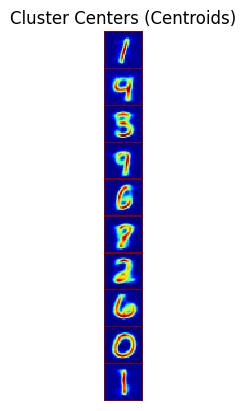

In [25]:
print("Plotting Centroids...")
A = display_network(kmeans.cluster_centers_.T, K, 1)
f1 = plt.figure(1)
plt.imshow(A, interpolation='nearest', cmap="jet")
plt.axis('off')
plt.title("Cluster Centers (Centroids)")
plt.show()

Finding Nearest Neighbors...
Plotting Nearest Neighbors...


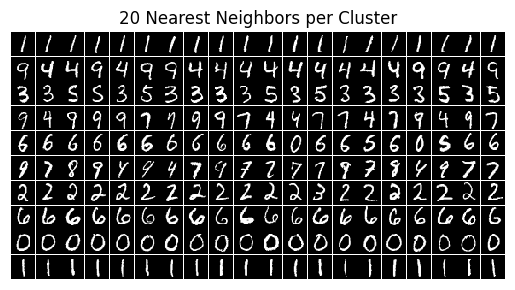

In [26]:
N0 = 20
X1 = np.zeros((N0 * K, 784))

print("Finding Nearest Neighbors...")
for k in range(K):
    # Get data belonging to cluster k
    Xk = X0[pred_label == k, :]

    # Get the center of cluster k
    center_k = [kmeans.cluster_centers_[k]]

    # Fit Nearest Neighbors on the data of this cluster
    neigh = NearestNeighbors(n_neighbors=N0).fit(Xk)

    # Find N0 closest points to the center
    dist, nearest_id = neigh.kneighbors(center_k, N0)

    # --- FIX: Use nearest_id[0] to get the 1D indices ---
    X1[N0 * k : N0 * k + N0, :] = Xk[nearest_id[0], :]

# --- PLOT 2: Nearest Neighbors ---
print("Plotting Nearest Neighbors...")
# --- FIX: passed X1 instead of X2 ---
A_neighbors = display_network(X1.T, K, N0)

f2 = plt.figure(2)
plt.imshow(A_neighbors, interpolation='nearest', cmap='gray')
plt.axis('off')
plt.title("20 Nearest Neighbors per Cluster")
plt.show()

# Bài 1.1

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # Cần thêm thư viện này cho hàm cdist
from mnist import MNIST

In [28]:
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        if len(Xk) > 0: # Tránh lỗi chia cho 0 nếu cụm rỗng
            centers[k,:] = np.mean(Xk, axis = 0)
    return centers

def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) ==
            set([tuple(a) for a in new_centers]))

def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    print("Bắt đầu chạy K-Means...")
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            print(f"Hội tụ sau {it} vòng lặp.")
            break
        centers.append(new_centers)
        it += 1
        # In ra tiến độ để đỡ sốt ruột
        if it % 5 == 0:
            print(f"Vòng lặp thứ {it}...")
    return (centers, labels, it)

In [29]:
def viz_centroids(centers):
    K = centers.shape[0]
    plt.figure(figsize=(10, 4))
    for k in range(K):
        plt.subplot(2, 5, k + 1)
        # Reshape vector 784 chiều thành ảnh 28x28
        image = centers[k].reshape(28, 28)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title(f"Cluster {k}")
    plt.tight_layout()
    plt.show()

Bắt đầu chạy K-Means...
Vòng lặp thứ 5...
Vòng lặp thứ 10...
Vòng lặp thứ 15...
Hội tụ sau 16 vòng lặp.
Centers found by our algorithm:


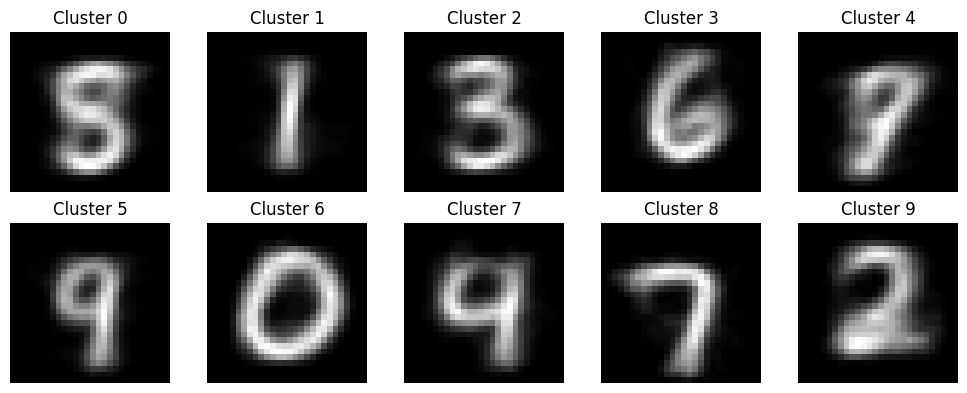

In [30]:
try:
    # Load dữ liệu
    mndata = MNIST('MNIST/') # Đảm bảo thư mục MNIST nằm cùng chỗ file code
    mndata.load_testing()
    X = np.array(mndata.test_images)

    # Chuẩn hóa dữ liệu về [0, 1] để thuật toán chạy tốt hơn
    X = X / 256.0

    # Lấy mẫu thử
    X = X[:1000, :]

    # Thiết lập số cụm K = 10 (cho 10 chữ số từ 0-9)
    K = 10
    (centers, labels, it) = kmeans(X, K)

    print('Centers found by our algorithm:')
    # Lấy bộ centers cuối cùng để hiển thị
    final_centers = centers[-1]

    # Hiển thị kết quả
    viz_centroids(final_centers)

except Exception as e:
    print(f"Có lỗi xảy ra: {e}")
    print("Vui lòng kiểm tra lại đường dẫn thư mục 'MNIST/'")

# Bài 1.2

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

In [40]:
def kmeans_init_centers(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_assign_labels(X, centers):
    # Tính khoảng cách từ điểm dữ liệu đến các tâm
    D = cdist(X, centers)
    # Trả về chỉ số của tâm gần nhất
    return np.argmin(D, axis=1)

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        Xk = X[labels == k, :]
        if len(Xk) > 0:
            centers[k, :] = np.mean(Xk, axis=0)
    return centers

def has_converged(centers, new_centers):
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    print("-> Đang huấn luyện (tìm tâm cụm)...")
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

def kmeans_predict(X_test, centers):
    # Đối với K-Means, "predict" chính là tìm cụm gần nhất
    # dựa trên các centers đã học được từ tập train
    return kmeans_assign_labels(X_test, centers)

In [33]:
def load_data(folder_path, label_value, num_samples=500, img_size=(50, 50)):
    data = []
    labels = []
    count = 0

    # Kiểm tra đường dẫn
    if not os.path.exists(folder_path):
        print(f"Lỗi: Không tìm thấy thư mục {folder_path}")
        return np.array([]), np.array([])

    files = os.listdir(folder_path)
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, file)
            # Đọc ảnh màu
            img = cv2.imread(img_path)
            if img is not None:
                # Resize nhỏ lại để thuật toán chạy nổi
                img = cv2.resize(img, img_size)
                # Duỗi phẳng (50x50x3 -> 7500 chiều)
                data.append(img.flatten())
                labels.append(label_value)
                count += 1
            if count >= num_samples:
                break
    return np.array(data), np.array(labels)

In [34]:
def evaluate_result(pred_labels, true_labels):
    # Vì K-Means là không giám sát, ta không biết Cluster 0 là Chó hay Mèo.
    # Ta phải thử 2 trường hợp để xem trường hợp nào đúng logic hơn.

    # Giả sử Cluster 0 = Chó (Label 0), Cluster 1 = Mèo (Label 1)
    acc_1 = np.mean(pred_labels == true_labels)

    # Giả sử Cluster 0 = Mèo (Label 1), Cluster 1 = Chó (Label 0)
    # Tức là đảo ngược pred_labels (0 thành 1, 1 thành 0)
    acc_2 = np.mean((1 - pred_labels) == true_labels)

    return max(acc_1, acc_2)

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [41]:
TRAIN_DIR_DOG = 'cats_and_dogs_filtered/cats_and_dogs_filtered/train/dogs'
TRAIN_DIR_CAT = 'cats_and_dogs_filtered/cats_and_dogs_filtered/train/cats'
TEST_DIR_DOG  = 'cats_and_dogs_filtered/cats_and_dogs_filtered/validation/dogs'
TEST_DIR_CAT  = 'cats_and_dogs_filtered/cats_and_dogs_filtered/validation/cats'

IMG_SIZE = (50, 50) # Kích thước ảnh resize
N_TRAIN = 500       # Số lượng ảnh train mỗi loại
N_TEST = 100        # Số lượng ảnh test mỗi loại

# ================= BƯỚC 1: LOAD DỮ LIỆU =================
print("1. Đang load dữ liệu Train...")
X_train_dog, y_train_dog = load_data(TRAIN_DIR_DOG, 0, N_TRAIN, IMG_SIZE) # 0 = Dog
X_train_cat, y_train_cat = load_data(TRAIN_DIR_CAT, 1, N_TRAIN, IMG_SIZE) # 1 = Cat

X_train = np.concatenate((X_train_dog, X_train_cat), axis=0) / 255.0
y_train = np.concatenate((y_train_dog, y_train_cat), axis=0)

print("2. Đang load dữ liệu Test...")
X_test_dog, y_test_dog = load_data(TEST_DIR_DOG, 0, N_TEST, IMG_SIZE)
X_test_cat, y_test_cat = load_data(TEST_DIR_CAT, 1, N_TEST, IMG_SIZE)

X_test = np.concatenate((X_test_dog, X_test_cat), axis=0) / 255.0
y_test = np.concatenate((y_test_dog, y_test_cat), axis=0)

# ================= BƯỚC 2: HUẤN LUYỆN (TRAINING) =================
# Tìm ra 2 tâm cụm đại diện
(centers_history, labels_history, it) = kmeans(X_train, K=2)
final_centers = centers_history[-1]
train_labels_pred = labels_history[-1]

# ================= BƯỚC 3: XÁC ĐỊNH NHÃN CỦA CỤM (MAPPING) =================
# K-Means không biết Cụm 0 là Chó hay Mèo. Ta phải kiểm tra thống kê.
# Tính độ chính xác nếu giả sử Cụm 0 = Chó (Label 0)
acc_option_1 = accuracy_score(y_train, train_labels_pred)
# Tính độ chính xác nếu giả sử Cụm 0 = Mèo (Label 1) - tức là đảo ngược kết quả
acc_option_2 = accuracy_score(y_train, 1 - train_labels_pred)

if acc_option_1 > acc_option_2:
    print(f"-> Mapping: Cluster 0 là Chó (0), Cluster 1 là Mèo (1)")
    mapping_reverse = False
else:
    print(f"-> Mapping: Cluster 0 là Mèo (1), Cluster 1 là Chó (0)")
    mapping_reverse = True

# ================= BƯỚC 4: CHẠY TRÊN TẬP TEST =================
print("\n3. Đang dự đoán trên tập Test...")

# Tìm cụm gần nhất cho các ảnh test
test_clusters = kmeans_predict(X_test, final_centers)

# Chuyển đổi từ số cụm sang nhãn Chó/Mèo thực tế dựa trên Mapping ở trên
if mapping_reverse:
    final_test_pred = 1 - test_clusters
else:
    final_test_pred = test_clusters

# ================= BƯỚC 5: ĐÁNH GIÁ KẾT QUẢ =================
acc = accuracy_score(y_test, final_test_pred)
cm = confusion_matrix(y_test, final_test_pred)

print(f"\n======== KẾT QUẢ TRÊN TẬP TEST ========")
print(f"Số lượng ảnh test: {len(y_test)}")
print(f"Độ chính xác (Accuracy): {acc * 100:.2f}%")
print("Confusion Matrix:")
print(cm)
print("(Hàng: Thực tế [Chó, Mèo], Cột: Dự đoán [Chó, Mèo])")

if acc < 0.6:
    print("\nLưu ý: Kết quả thấp là BÌNH THƯỜNG.")
    print("K-Means dựa trên pixel thô không thể phân biệt tốt chó/mèo do nhiễu nền và màu sắc.")
    print("Cần dùng CNN trích xuất đặc trưng để cải thiện.")

1. Đang load dữ liệu Train...
2. Đang load dữ liệu Test...
-> Đang huấn luyện (tìm tâm cụm)...
-> Mapping: Cluster 0 là Chó (0), Cluster 1 là Mèo (1)

3. Đang dự đoán trên tập Test...

======== KẾT QUẢ TRÊN TẬP TEST ========
Số lượng ảnh test: 200
Độ chính xác (Accuracy): 48.00%
Confusion Matrix:
[[49 51]
 [53 47]]
(Hàng: Thực tế [Chó, Mèo], Cột: Dự đoán [Chó, Mèo])

Lưu ý: Kết quả thấp là BÌNH THƯỜNG.
K-Means dựa trên pixel thô không thể phân biệt tốt chó/mèo do nhiễu nền và màu sắc.
Cần dùng CNN trích xuất đặc trưng để cải thiện.



Đang tính toán PCA để vẽ biểu đồ phân tán...


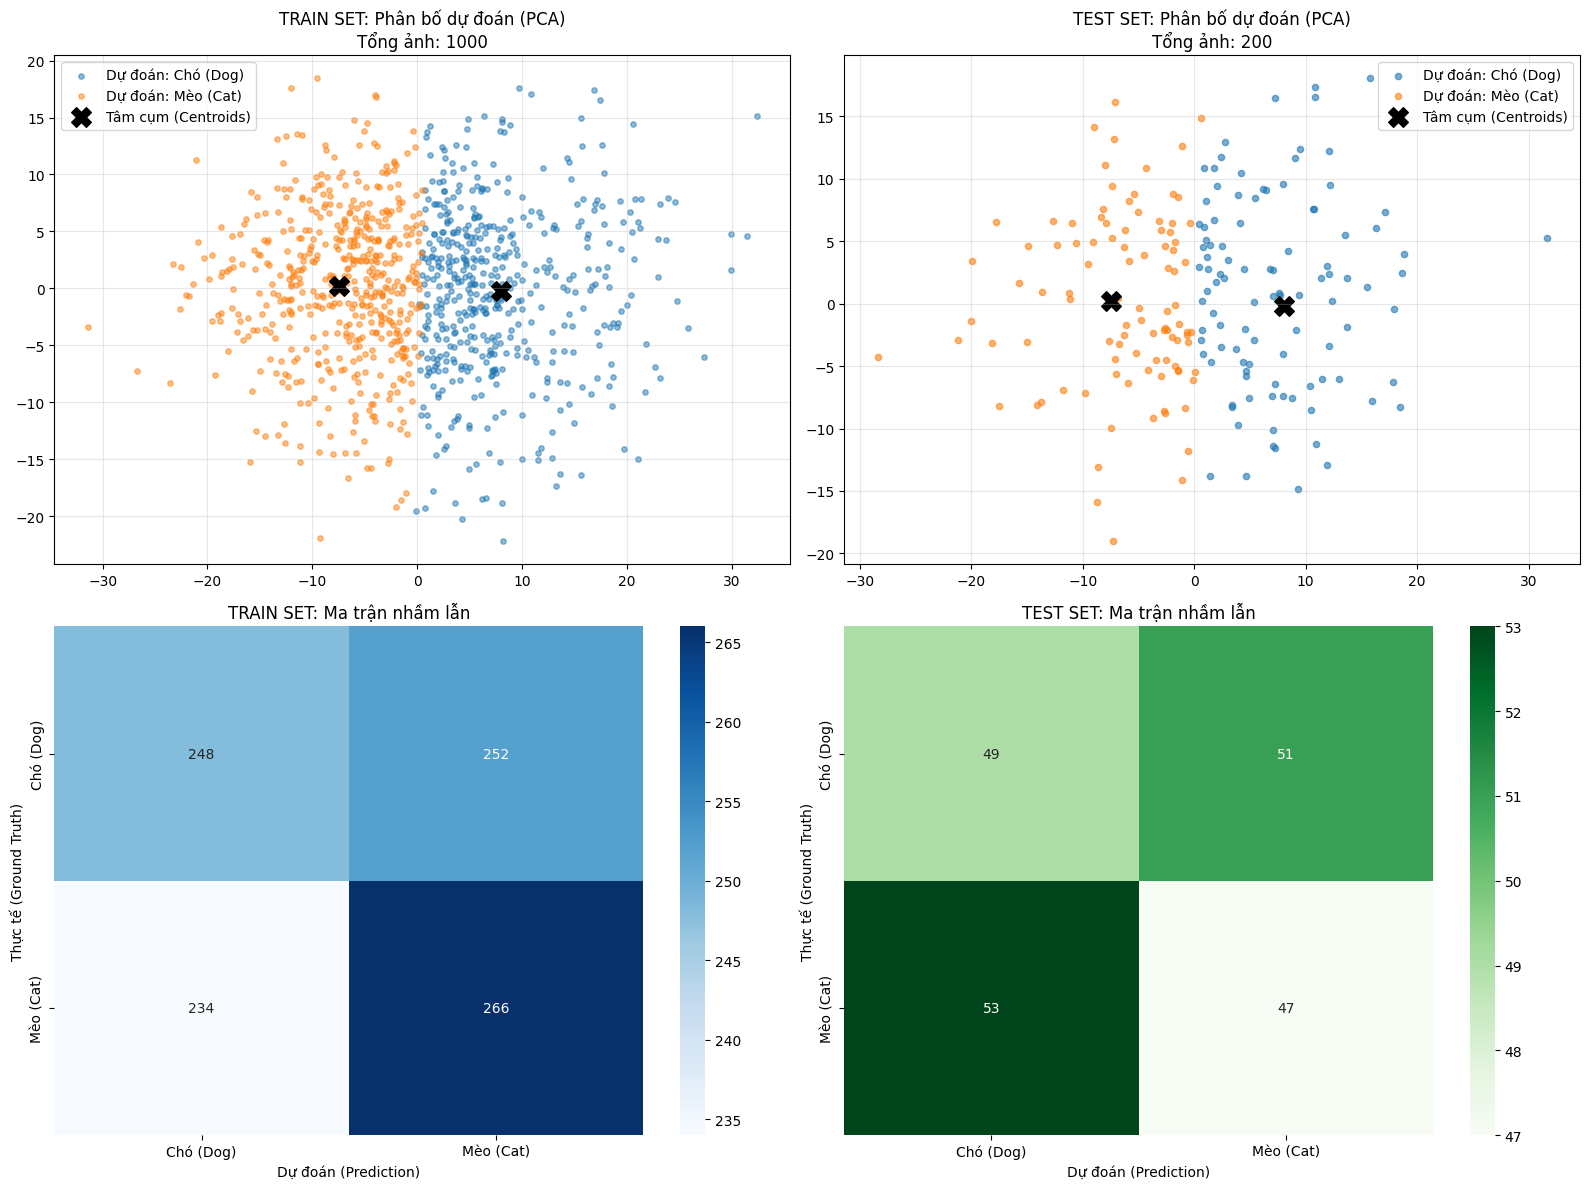

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns # Thư viện vẽ biểu đồ đẹp (nếu chưa có thì pip install seaborn)
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

def visualize_full_results(X_train, y_train_pred, y_train_true,
                           X_test, y_test_pred, y_test_true,
                           centers):

    print("\nĐang tính toán PCA để vẽ biểu đồ phân tán...")

    # 1. Giảm chiều dữ liệu xuống 2D để vẽ
    pca = PCA(n_components=2)
    # Fit vào tập train
    X_train_2d = pca.fit_transform(X_train)
    # Transform tập test và centers theo quy luật của tập train
    X_test_2d = pca.transform(X_test)
    centers_2d = pca.transform(centers)

    # Thiết lập màu sắc
    colors = ['#1f77b4', '#ff7f0e'] # Xanh và Cam
    markers = ['o', 's']
    labels = ['Chó (Dog)', 'Mèo (Cat)']

    # TẠO FIGURE LỚN
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # --- BIỂU ĐỒ 1: SCATTER PLOT - TRAINING SET ---
    ax1 = axes[0, 0]
    for k in range(2):
        # Lấy các điểm thuộc cụm k
        mask = (y_train_pred == k)
        ax1.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1],
                    c=colors[k], label=f'Dự đoán: {labels[k]}', alpha=0.5, s=15)

    # Vẽ tâm cụm
    ax1.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=200, marker='X', label='Tâm cụm (Centroids)')
    ax1.set_title(f"TRAIN SET: Phân bố dự đoán (PCA)\nTổng ảnh: {len(y_train_true)}")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- BIỂU ĐỒ 2: SCATTER PLOT - TEST SET ---
    ax2 = axes[0, 1]
    for k in range(2):
        mask = (y_test_pred == k)
        ax2.scatter(X_test_2d[mask, 0], X_test_2d[mask, 1],
                    c=colors[k], label=f'Dự đoán: {labels[k]}', alpha=0.6, s=20)

    # Vẽ lại tâm cụm cũ lên không gian test
    ax2.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=200, marker='X', label='Tâm cụm (Centroids)')
    ax2.set_title(f"TEST SET: Phân bố dự đoán (PCA)\nTổng ảnh: {len(y_test_true)}")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # --- BIỂU ĐỒ 3: CONFUSION MATRIX - TRAIN ---
    ax3 = axes[1, 0]
    cm_train = confusion_matrix(y_train_true, y_train_pred)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=labels, yticklabels=labels)
    ax3.set_title("TRAIN SET: Ma trận nhầm lẫn")
    ax3.set_ylabel('Thực tế (Ground Truth)')
    ax3.set_xlabel('Dự đoán (Prediction)')

    # --- BIỂU ĐỒ 4: CONFUSION MATRIX - TEST ---
    ax4 = axes[1, 1]
    cm_test = confusion_matrix(y_test_true, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=ax4,
                xticklabels=labels, yticklabels=labels)
    ax4.set_title("TEST SET: Ma trận nhầm lẫn")
    ax4.set_ylabel('Thực tế (Ground Truth)')
    ax4.set_xlabel('Dự đoán (Prediction)')

    plt.tight_layout()
    plt.show()

# --- GỌI HÀM NÀY SAU KHI ĐÃ CHẠY XONG CODE TRƯỚC ---
# Lưu ý: Các biến X_train, y_train, train_labels_pred... phải có từ bước trước
try:
    visualize_full_results(
        X_train, train_labels_pred, y_train,   # Dữ liệu Train + Nhãn dự đoán + Nhãn thật
        X_test, final_test_pred, y_test,       # Dữ liệu Test + Nhãn dự đoán + Nhãn thật
        final_centers                          # Tâm cụm tìm được
    )
except NameError:
    print("Vui lòng chạy phần huấn luyện (code trước) để có các biến dữ liệu trước khi vẽ!")
except Exception as e:
    print(f"Lỗi: {e}")
    print("Nếu lỗi thiếu thư viện seaborn, hãy cài bằng lệnh: pip install seaborn")

# Ví dụ 2.1

Đang tính toán ma trận khoảng cách...
Bắt đầu chạy DBSCAN...
Hoàn thành! Tìm thấy 2 cụm.


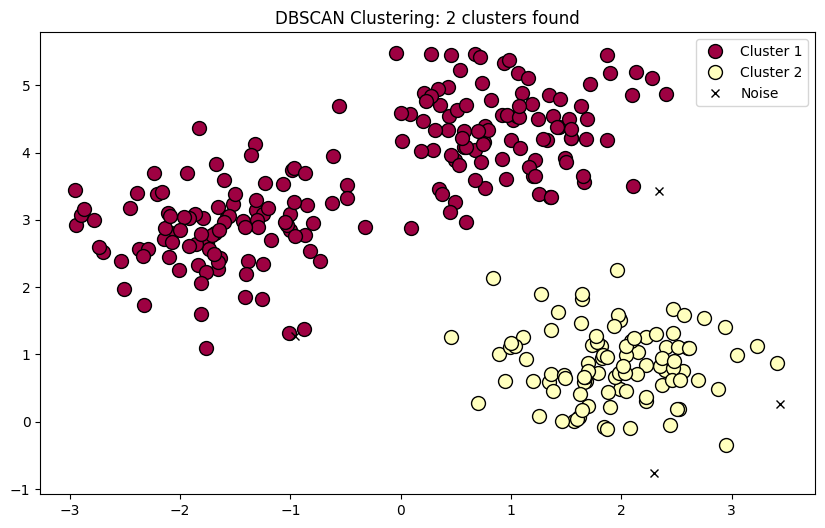

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

class DBSCAN(object):
    def __init__(self, x, epsilon, minpts):
        self.input = x
        self.epsilon = epsilon
        self.minpts = minpts
        self.n = len(x)

        # DBSCAN Parameters
        # 0: Unclassified, -1: Noise, >0: Cluster ID
        self.idx = np.full((self.n), 0)
        self.visited = np.full((self.n), False)
        self.C = 0 # Cluster Counter

        # Tính toán ma trận khoảng cách (Euclidean distance matrix)
        # Lưu ý: Cách này tốn bộ nhớ với dữ liệu lớn (O(N^2))
        print("Đang tính toán ma trận khoảng cách...")
        p, q = np.meshgrid(np.arange(self.n), np.arange(self.n))
        self.dist = np.sqrt(np.sum(((x[p] - x[q])**2), axis=2))

    def regionQuery(self, i):
        """Trả về danh sách index các điểm nằm trong bán kính epsilon"""
        # Lấy dòng thứ i của ma trận khoảng cách, so sánh với epsilon
        g = self.dist[i, :] < self.epsilon
        # np.where trả về tuple, lấy phần tử đầu tiên
        Neighbors = np.where(g)[0].tolist()
        return Neighbors

    def expandCluster(self, i, neighbors):
        """Mở rộng cụm từ điểm i"""
        self.idx[i] = self.C

        k = 0
        while k < len(neighbors):
            j = neighbors[k]

            # Nếu điểm chưa được thăm
            if not self.visited[j]:
                self.visited[j] = True
                neighbors2 = self.regionQuery(j)

                # Nếu điểm j cũng là core point (đủ hàng xóm)
                if len(neighbors2) >= self.minpts:
                    # Nối thêm các hàng xóm mới vào danh sách cần duyệt
                    # (Lưu ý: cách cộng list này có thể chậm với dữ liệu cực lớn)
                    neighbors = neighbors + neighbors2

            # Nếu điểm j chưa thuộc cụm nào thì gán vào cụm hiện tại
            if self.idx[j] == 0:
                self.idx[j] = self.C

            k += 1

    def fit(self):
        """Hàm chính để chạy thuật toán"""
        print("Bắt đầu chạy DBSCAN...")
        for i in range(self.n):
            if self.visited[i]:
                continue

            self.visited[i] = True
            neighbors = self.regionQuery(i)

            if len(neighbors) < self.minpts:
                # Đánh dấu là Noise (-1)
                self.idx[i] = -1
            else:
                # Tìm thấy cụm mới -> Tăng bộ đếm C và mở rộng
                self.C += 1
                self.expandCluster(i, neighbors)

        print(f"Hoàn thành! Tìm thấy {self.C} cụm.")
        return self.idx

# --- PHẦN TEST VÀ TRỰC QUAN HÓA ---

# 1. Tạo dữ liệu mẫu (3 cụm hình tròn)
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# 2. Khởi tạo và chạy DBSCAN
# epsilon=0.5, minpts=5 là tham số thường dùng cho dạng dữ liệu này
dbscan = DBSCAN(X, epsilon=0.6, minpts=5)
labels = dbscan.fit()

# 3. Vẽ biểu đồ kết quả
plt.figure(figsize=(10, 6))

# Lấy danh sách các cụm tìm được
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Màu đen cho điểm nhiễu (Noise)
        col = [0, 0, 0, 1]
        label_name = "Noise"
        marker = 'x'
    else:
        label_name = f"Cluster {k}"
        marker = 'o'

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], marker, markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10 if k != -1 else 6, label=label_name)

plt.title(f'DBSCAN Clustering: {len(unique_labels)-1 if -1 in unique_labels else len(unique_labels)} clusters found')
plt.legend()
plt.show()

# Bài tập 2.1

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs

In [46]:
X, y = make_blobs(n_samples=500, centers=3, cluster_std=0.60, random_state=0)

In [47]:
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        if len(Xk) > 0:
            centers[k,:] = np.mean(Xk, axis = 0)
    return centers

def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) ==
            set([tuple(a) for a in new_centers]))

def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    print("Bắt đầu chạy K-Means...")
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            print(f"Hội tụ sau {it} vòng lặp.")
            break
        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

In [48]:
def kmeans_display(X, label, centers=None):
    K = np.amax(label) + 1
    # Danh sách màu và marker để vẽ
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = ['o', 's', '^', 'v', '<', '>', 'p']

    plt.figure(figsize=(8, 6))

    # Vẽ từng cụm
    for k in range(K):
        # Lấy dữ liệu thuộc cụm k
        Xk = X[label == k, :]
        # Vẽ điểm dữ liệu
        plt.plot(Xk[:, 0], Xk[:, 1],
                 color=colors[k % len(colors)], # Chọn màu
                 marker=markers[k % len(markers)], # Chọn kiểu điểm
                 linestyle='', markersize=5, alpha=0.6, label=f'Cluster {k}')

    # Vẽ tâm cụm (nếu có truyền vào)
    if centers is not None:
        plt.plot(centers[:, 0], centers[:, 1], 'y*', markersize=15, markeredgecolor='k', label='Centers')

    plt.axis('equal')
    plt.title('Kết quả phân cụm K-Means')
    plt.legend()
    plt.show()

Bắt đầu chạy K-Means...
Hội tụ sau 12 vòng lặp.
Centers found by our algorithm:
[[ 1.62460035  0.46661806]
 [-0.33625882  3.65205218]
 [ 2.35072952  1.32322051]]


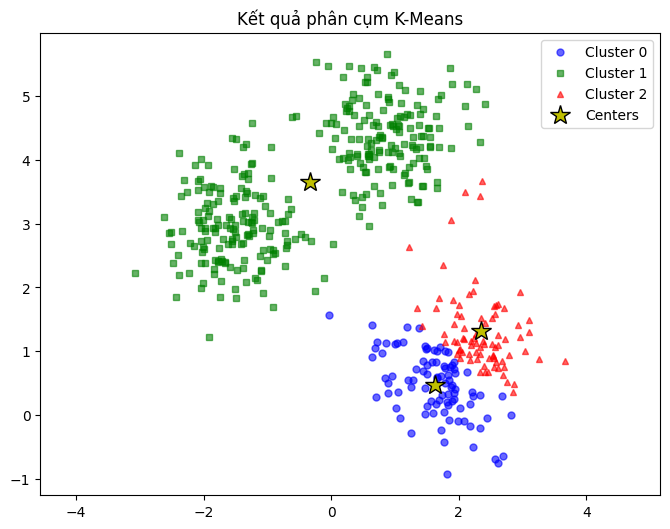

In [49]:
K = 3

# Gọi hàm K-Means
(centers, labels, it) = kmeans(X, K)

print('Centers found by our algorithm:')
print(centers[-1])

# Hiển thị kết quả cuối cùng
kmeans_display(X, labels[-1], centers[-1])

# Bài tập 2.2

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [51]:
class DBSCAN(object):
    def __init__(self, x, epsilon, minpts):
        self.input = x
        self.epsilon = epsilon
        self.minpts = minpts
        self.n = len(x)
        self.idx = np.full((self.n), 0)
        self.visited = np.full((self.n), False)
        self.C = 0

        # Tính ma trận khoảng cách
        p, q = np.meshgrid(np.arange(self.n), np.arange(self.n))
        self.dist = np.sqrt(np.sum(((x[p] - x[q])**2), axis=2))

    def regionQuery(self, i):
        g = self.dist[i, :] < self.epsilon
        Neighbors = np.where(g)[0].tolist()
        return Neighbors

    def expandCluster(self, i, neighbors):
        self.idx[i] = self.C
        k = 0
        while k < len(neighbors):
            j = neighbors[k]
            if not self.visited[j]:
                self.visited[j] = True
                neighbors2 = self.regionQuery(j)
                if len(neighbors2) >= self.minpts:
                    neighbors = neighbors + neighbors2
            if self.idx[j] == 0:
                self.idx[j] = self.C
            k += 1

    def fit(self):
        for i in range(self.n):
            if self.visited[i]: continue
            self.visited[i] = True
            neighbors = self.regionQuery(i)
            if len(neighbors) < self.minpts:
                self.idx[i] = -1 # Noise
            else:
                self.C += 1
                self.expandCluster(i, neighbors)
        return self.idx

In [52]:
def find_optimal_epsilon(X, minpts_fixed=5):
    print(f"Đang dò tìm epsilon để số cụm nằm trong khoảng [5, 15] (MinPts={minpts_fixed})...")

    # Thử epsilon từ 0.5 đến 5.0 (bước nhảy 0.1)
    # Vì dữ liệu Normalized nằm trong [0,1] nhưng khoảng cách Euclidean qua 52 tuần có thể lớn hơn 1
    best_eps = -1
    best_labels = []
    best_n_clusters = -1

    for eps in np.arange(0.5, 5.0, 0.1):
        # Khởi tạo và chạy DBSCAN
        model = DBSCAN(X, epsilon=eps, minpts=minpts_fixed)
        labels = model.fit()

        # Đếm số cụm (loại bỏ nhãn -1 là nhiễu)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Kiểm tra điều kiện bài toán
        if 5 <= n_clusters <= 15:
            print(f"-> Tìm thấy! Epsilon={eps:.2f} cho ra {n_clusters} cụm.")
            return eps, labels, n_clusters

    print("Không tìm thấy epsilon phù hợp trong khoảng thử nghiệm.")
    return None, None, None

Đang tải dữ liệu từ URL (hoặc đọc file local)...
Kích thước dữ liệu: (811, 52) (Sản phẩm x Tuần)
Đang dò tìm epsilon để số cụm nằm trong khoảng [5, 15] (MinPts=5)...
-> Tìm thấy! Epsilon=1.30 cho ra 5 cụm.

KẾT QUẢ PHÂN CỤM (Epsilon=1.30)
Cụm 1: 5 sản phẩm
  -> Ví dụ: P215, P245, P279, P457, P656 ...
Cụm 2: 5 sản phẩm
  -> Ví dụ: P234, P250, P469, P655, P712 ...
Cụm 3: 27 sản phẩm
  -> Ví dụ: P240, P246, P252, P255, P274 ...
Cụm 4: 5 sản phẩm
  -> Ví dụ: P262, P286, P406, P512, P615 ...
Cụm 5: 1 sản phẩm
  -> Ví dụ: P808 ...
Noise (Nhiễu): 768 sản phẩm

Đang vẽ biểu đồ PCA...


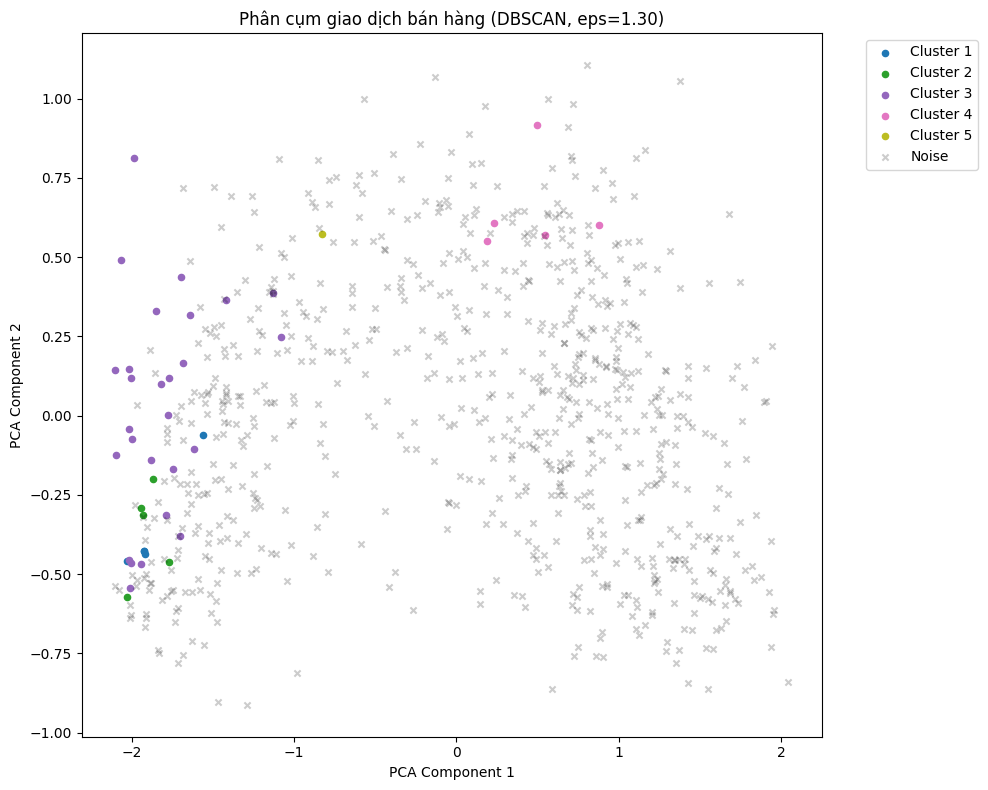

In [53]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv"
try:
    print("Đang tải dữ liệu từ URL (hoặc đọc file local)...")
    # Nếu bạn có file máy thì đổi url thành tên file 'Sales_Transactions_Dataset_Weekly.csv'
    df = pd.read_csv(url)
except Exception as e:
    print("Lỗi tải dữ liệu. Hãy đảm bảo bạn có internet hoặc đã tải file csv về máy.")
    exit()

# Lấy cột Product_Code để định danh sau này
product_codes = df['Product_Code'].values

# 2. Tiền xử lý: Chọn dữ liệu Normalized (từ cột Normalized 0 đến Normalized 51)
# Các cột này thường nằm ở nửa sau của file. Ta lọc theo tên cột bắt đầu bằng 'Normalized'
norm_cols = [col for col in df.columns if col.startswith('Normalized')]
X = df[norm_cols].values

print(f"Kích thước dữ liệu: {X.shape} (Sản phẩm x Tuần)")

# 3. Chạy thuật toán để tìm cụm
# Chọn minpts = 4 hoặc 5 (thường dùng cho dữ liệu ít nhiễu)
optimal_eps, labels, n_clusters = find_optimal_epsilon(X, minpts_fixed=5)

if optimal_eps is not None:
    # 4. Hiển thị kết quả chi tiết
    print("\n" + "="*30)
    print(f"KẾT QUẢ PHÂN CỤM (Epsilon={optimal_eps:.2f})")
    print("="*30)

    # Thống kê số lượng sản phẩm mỗi cụm
    unique_labels = set(labels)
    for k in unique_labels:
        count = np.sum(labels == k)
        if k == -1:
            print(f"Noise (Nhiễu): {count} sản phẩm")
        else:
            print(f"Cụm {k}: {count} sản phẩm")
            # In thử 5 sản phẩm đầu tiên của cụm
            products_in_cluster = product_codes[labels == k]
            print(f"  -> Ví dụ: {', '.join(products_in_cluster[:5])} ...")

    # 5. Trực quan hóa bằng PCA (Giảm 52 chiều xuống 2 chiều)
    print("\nĐang vẽ biểu đồ PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))

    # Tạo bảng màu
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 0.2] # Màu đen mờ cho nhiễu
            label_name = "Noise"
            marker = 'x'
        else:
            label_name = f"Cluster {k}"
            marker = 'o'

        mask = (labels == k)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[col], label=label_name, s=20, marker=marker)

    plt.title(f'Phân cụm giao dịch bán hàng (DBSCAN, eps={optimal_eps:.2f})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("Hãy thử thay đổi khoảng epsilon hoặc minpts trong hàm find_optimal_epsilon.")